## **Data Loading and Preprocessing**

#### Load Hotel Data from CSV file

In [29]:
import os
import pandas as pd
# Load input_data_dfs from CSV files
input_data_dfs = {}

input_data_dir = '../Gen_sen/data_pre/input_data'
for filename in os.listdir(input_data_dir):
    if filename.endswith('_input_data.csv'):
        hotel_name = filename.replace('_input_data.csv', '')
        input_data_dfs[hotel_name] = pd.read_csv(os.path.join(input_data_dir, filename))

print("Hotel data and input data loaded successfully.")

Hotel data and input data loaded successfully.


#### Train and Test Split

In [2]:
from sklearn.model_selection import train_test_split

train_data_per_hotel = {}
test_data_per_hotel = {}

for hotel_name, df in input_data_dfs.items():
    # Split the dataset into training and testing sets
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        df['cleaned_content'], 
        df['label'], 
        test_size=0.3,
        stratify=df['label'], 
        random_state=42
    )
    train_data_per_hotel[hotel_name] = (X_train_raw, y_train)
    test_data_per_hotel[hotel_name] = (X_test_raw, y_test)

#### Combine and Shuffle Data 

In [3]:
from sklearn.utils import shuffle

# Combine all training data
combined_X_train = []
combined_y_train = []

for hotel_name, (X_train_raw, y_train) in train_data_per_hotel.items():
    combined_X_train.extend(X_train_raw)
    combined_y_train.extend(y_train)

# Combine all testing data
combined_X_test = []
combined_y_test = []

for hotel_name, (X_test_raw, y_test) in test_data_per_hotel.items():
    combined_X_test.extend(X_test_raw)
    combined_y_test.extend(y_test)

print("Combined training and testing data successfully.")

combined_X_train, combined_y_train = shuffle(combined_X_train, combined_y_train, random_state=42)
combined_X_test, combined_y_test = shuffle(combined_X_test, combined_y_test, random_state=42)

print("Data shuffled successfully.")

Combined training and testing data successfully.
Data shuffled successfully.


## **Text Tokenziation and Padding**

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def prepare_data(data, tokenizer, maxlen=100):
    sequences = tokenizer.texts_to_sequences(data)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    return padded_sequences

# Constant
NUM_WORDS = 2200
MAX_LENGTH = 75

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(combined_X_train)

print(combined_X_train)
# Prepare training data
padded_sequences = prepare_data(combined_X_train, tokenizer, MAX_LENGTH)
train_data = (padded_sequences, np.array(combined_y_train))

# Prepare testing data
padded_sequences_test = prepare_data(combined_X_test, tokenizer)
test_data = (padded_sequences_test, np.array(combined_y_test))

['helpdesk helpful incident need quiet room quick conference call late due terrible traffic early check book conference room instead front desk giving bad look brought room charge peso per hour conference room dirty leftover food previous user one bother clean nd day got lockout could take luggage check went front desk request new keycard could retrieve luggage checking asked queue behind long queue check took min minding request could go retrieve luggage non front desk helpful pricewise par service provided', 'room nice housekeeping gave exceptional service special mention maria khino telephone staff keen detail prompt request delivered agad back sure soon recommend friend thank bai kudos management happy service staying room', 'really good view infinity swimming pool staff really awake got invalided room key kept changing room king size bed twin really nice supportive staff still', 'nice hotel near airport cebu city casino building surely make people staying probably customer one nig

## **Model Building and Training**

##### **Resampling**

In [5]:
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

# Define a function to choose the resampling method
def resample_data(X_train, y_train, method='SMOTE'): 
    # Select resampling method
    if method == 'SMOTE':
        resampler = SMOTE(random_state=42)
    elif method == 'ADASYN':
        resampler = ADASYN(random_state=42)
    elif method == 'RandomUnderSampler':
        resampler = RandomUnderSampler(random_state=42)
    elif method == 'RandomOverSampler':
        resampler = RandomOverSampler(random_state=42)
    elif method == 'SMOTEENN':
        resampler = SMOTEENN(random_state=42)
    elif method == 'SMOTETomek':
        resampler = SMOTETomek(random_state=42)
    else:
        print("Unknown resampling method. Choose 'SMOTE', 'ADASYN', 'RandomUnderSampler', 'RandomOverSampler', 'SMOTEENN', or 'SMOTETomek'. Returning unsampled data")
        return X_train, y_train
    
    # Perform resampling
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    print(f"Resampled dataset shape y: {Counter(y_resampled)}")
    print(f"Resampled dataset shape X: {len(X_resampled)}")
    
    return X_resampled, y_resampled


#### **Models**

##### Imports

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten

##### CNN Model Architecture

In [22]:
def build_cnn_model(vocab_size, num_classes, embedding_dim=128, conv_filters=128, kernel_size=5, dense_units=128, dropout_rate=0.5):
    model = Sequential()
    # Embedding layer to represent each word with a vector
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    # 1D Convolutional layer with ReLU activation
    model.add(Conv1D(conv_filters, kernel_size, activation='relu'))
    # Batch normalization layer
    model.add(BatchNormalization())
    # Global max pooling to reduce dimensionality
    model.add(GlobalMaxPooling1D())
    # Dense layer with ReLU activation
    model.add(Dense(dense_units, activation='relu'))
    # Batch normalization layer
    model.add(BatchNormalization())
    # Dropout layer to prevent overfitting
    model.add(Dropout(dropout_rate))
    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model



In [25]:
def build_cnn_model_l2(vocab_size, num_classes, embedding_dim=128, l2_input = 0.001, conv_filters=128, kernel_size=5, dense_units=128, dropout_rate=0.5):
    model = Sequential()
    # Embedding layer to represent each word with a vector
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    # 1D Convolutional layer with ReLU activation
    model.add(Conv1D(conv_filters, kernel_size, activation='relu', kernel_regularizer=l2(l2_input)))
    # Batch normalization layer
    model.add(BatchNormalization())
    # Global max pooling to reduce dimensionality
    model.add(GlobalMaxPooling1D())
    # Dense layer with ReLU activation
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001)))
       # Batch normalization layer
    model.add(BatchNormalization())
    # Dropout layer to prevent overfitting
    model.add(Dropout(dropout_rate))
    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

##### biLSTM Model Architecture

In [9]:
def build_bilstm_model(vocab_size, embedding_dim, num_classes, lstm_units=128, dropout_rate=0.5):
    model = Sequential()
    # Embedding Layer
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim))
    # BiLSTM Layer
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=False)))
    # Dropout for regularization
    model.add(Dropout(dropout_rate))
    # Dense Layer
    model.add(Dense(128, activation='relu'))
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

##### CNN-biLSTM Model Arhitecture

In [10]:
# Build the CNN model
def build_cnn_bilstm_model(vocab_size, embedding_dim, num_classes, kernel_size=3, filters=64, lstm_units=64, dropout_rate=0.5, l2_lambda=0.01):
    model = Sequential()
    # Embedding Layer
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    # Convolutional layer
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_lambda)))
    # Batch normalization layer
    model.add(BatchNormalization())
    # Max pooling layer
    model.add(MaxPooling1D(pool_size=2))
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(l2_lambda))))
    # Fully connected layer with ReLU activation and L2 regularization
    model.add(Dense(lstm_units, activation='relu', kernel_regularizer=l2(l2_lambda)))
    # Batch normalization layer
    model.add(BatchNormalization())
    # Dropout layer for regularization
    model.add(Dropout(dropout_rate))
    # Output layer with softmax activation for classification
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

### **Training**

##### Variables

In [51]:

kaggle_data = pd.read_csv('../Gen_sen/data_pre/kaggle/input_data.csv')

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(kaggle_data['cleaned_content'])

X = kaggle_data['cleaned_content']
X = prepare_data(X, tokenizer, MAX_LENGTH)

kaggle_X_train, kaggle_x_val, kaggle_y_train, kaggle_y_val = train_test_split( X, kaggle_data['label'], test_size=0.3, stratify=kaggle_data['label'], random_state=42)


In [56]:
# Model Constants
VOCAB_SIZE = NUM_WORDS
EMBEDDING_DIM = MAX_LENGTH
NUM_CLASSES = 3

# Train Constants
EPOCHS = 10
BATCH_SIZE = 32

# Get the training data
X_train, y_train = train_data

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Calculate class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

models = {}
histories = {}

##### CNN Training

In [53]:
cnn_model = build_cnn_model(vocab_size=10000, 
                            embedding_dim=EMBEDDING_DIM, 
                            num_classes=NUM_CLASSES,)

 #Train the model
cnn_history = cnn_model.fit(
    kaggle_X_train, 
    kaggle_y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
)
print("CNN model trained successfully.")

models['cnn'] = cnn_model
histories['cnn'] = cnn_history

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5679 - loss: 1.0579 - val_accuracy: 0.7268 - val_loss: 0.7858
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8806 - loss: 0.3267 - val_accuracy: 0.8018 - val_loss: 0.5973
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9573 - loss: 0.1352 - val_accuracy: 0.1895 - val_loss: 9.3701
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9802 - loss: 0.0651 - val_accuracy: 0.8036 - val_loss: 1.0222
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9779 - loss: 0.0686 - val_accuracy: 0.7882 - val_loss: 0.8797
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9750 - loss: 0.0758 - val_accuracy: 0.7749 - val_loss: 0.8133
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9806 - loss: 0.0652 - val_accuracy: 0.8137 - val_loss: 0.8496
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9828 - loss: 0.0549 - val_acc

##### CNN with Weights

In [62]:
cnn_with_weights = build_cnn_model(vocab_size=10000, 
                            embedding_dim=EMBEDDING_DIM, 
                            num_classes=NUM_CLASSES)

# Calculate class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(kaggle_y_train), y=kaggle_y_train)
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight('balanced', classes=unique_classes, y=kaggle_y_train)
class_weight_dict = {class_id: weight for class_id, weight in zip(unique_classes, class_weights_array)}

print(class_weight_dict)
unique_classes = np.unique(kaggle_y_train)
print("Unique classes:", unique_classes)

 #Train the model
cnn_history = cnn_with_weights.fit(
    kaggle_X_train, 
    kaggle_y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    class_weight=class_weight_dict
)
print("CNN model trained successfully.")

models['cnn_with_weights'] = cnn_with_weights
histories['cnn_with_weights'] = cnn_history

{0: 2.124258600237248, 1: 3.1272647893473042, 2: 0.45259533061637125}
Unique classes: [0 1 2]


KeyError: 2

In [26]:
cnn_model = build_cnn_model_l2(vocab_size=VOCAB_SIZE, 
                            embedding_dim=EMBEDDING_DIM, 
                            num_classes=NUM_CLASSES)

 #Train the model
cnn_history = cnn_model.fit(
    X_train, 
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val), 
    class_weight=class_weight_dict
)
print("CNN model trained successfully.")

models['cnn_weights_l2'] = cnn_model
histories['cnn_weights_l2'] = cnn_history

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4003 - loss: 1.6555 - val_accuracy: 0.1508 - val_loss: 1.3258
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6499 - loss: 0.9409 - val_accuracy: 0.2061 - val_loss: 1.3439
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8073 - loss: 0.5886 - val_accuracy: 0.7449 - val_loss: 1.0162
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8871 - loss: 0.4339 - val_accuracy: 0.8269 - val_loss: 0.7034
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9514 - loss: 0.3188 - val_accuracy: 0.7877 - val_loss: 0.7609
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9784 - loss: 0.2675 - val_accuracy: 0.8136 - val_loss: 0.7822
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9893 - loss: 0.2412 - val_accuracy: 0.7930 - val_loss: 0.8480
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9939 - loss: 0.2233 - val_accu

In [15]:
cnn_model = build_cnn_model(vocab_size=VOCAB_SIZE, 
                            embedding_dim=EMBEDDING_DIM, 
                            num_classes=NUM_CLASSES)

# Resample the training data
X_resampled, y_resampled = resample_data(X_train, y_train, method='SMOTE')
 #Train the model
cnn_history = cnn_model.fit(
    X_resampled, 
    y_resampled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val), 
    class_weight=class_weight_dict
)
print("CNN model trained successfully.")

models['cnn_smote'] = cnn_model
histories['cnn_smote'] = cnn_history

Resampled dataset shape y: Counter({2: 3611, 1: 3611, 0: 3611})
Resampled dataset shape X: 10833
Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3362 - loss: 2.4803 - val_accuracy: 0.0464 - val_loss: 2.0233
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3708 - loss: 1.9865 - val_accuracy: 0.0589 - val_loss: 1.8701
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4639 - loss: 1.6238 - val_accuracy: 0.1240 - val_loss: 1.8649
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6136 - loss: 1.0091 - val_accuracy: 0.3907 - val_loss: 1.2092
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7657 - loss: 0.5038 - val_accuracy: 0.4246 - val_loss: 1.3769
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8569 - loss: 0.2606 - val_accuracy: 0.4924 - val_loss: 1.5434
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9250 - loss: 0.1383 - val_accuracy: 0.5424 - val_loss: 1.4289
Epoch 8

In [16]:
cnn_model = build_cnn_model_l2(vocab_size=VOCAB_SIZE, 
                            embedding_dim=EMBEDDING_DIM, 
                            num_classes=NUM_CLASSES)

# Resample the training data
X_resampled, y_resampled = resample_data(X_train, y_train, method='SMOTE')
 #Train the model
cnn_history = cnn_model.fit(
    X_resampled, 
    y_resampled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val), 
    class_weight=class_weight_dict
)
print("CNN model trained successfully.")

models['cnn_smote_l2'] = cnn_model
histories['cnn_smote_l2'] = cnn_history

Resampled dataset shape y: Counter({2: 3611, 1: 3611, 0: 3611})
Resampled dataset shape X: 10833
Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3302 - loss: 2.6063 - val_accuracy: 0.0437 - val_loss: 2.4769
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3664 - loss: 2.1022 - val_accuracy: 0.0651 - val_loss: 2.1172
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4382 - loss: 1.8227 - val_accuracy: 0.0972 - val_loss: 2.0529
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5467 - loss: 1.3928 - val_accuracy: 0.1062 - val_loss: 2.0939
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6370 - loss: 0.9237 - val_accuracy: 0.1900 - val_loss: 1.8936
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7183 - loss: 0.6433 - val_accuracy: 0.2828 - val_loss: 1.6656
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7986 - loss: 0.4842 - val_accuracy: 0.3702 - val_loss: 1.9776
Ep

In [ ]:
cnn_model = build_cnn_model_l2(vocab_size=VOCAB_SIZE, 
                            embedding_dim=EMBEDDING_DIM, 
                            num_classes=NUM_CLASSES)

# Resample the training data
X_resampled, y_resampled = resample_data(X_train, y_train, method='SMOTE')
 #Train the model
cnn_history = cnn_model.fit(
    X_resampled, 
    y_resampled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val), 
    class_weight=class_weight_dict
)
print("CNN model trained successfully.")

models['cnn_weights_smote_l2'] = cnn_model
histories['cnn_weights_smote_l2'] = cnn_history

In [28]:
cnn_model = build_cnn_model_l2(vocab_size=VOCAB_SIZE, 
                            embedding_dim=EMBEDDING_DIM, 
                            num_classes=NUM_CLASSES)

# Resample the training data
X_resampled, y_resampled = resample_data(X_train, y_train, method='ADASYN')
 #Train the model
cnn_history = cnn_model.fit(
    X_resampled, 
    y_resampled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val), 
)
print("CNN model trained successfully.")

models['cnn_l2_ADASYNC'] = cnn_model
histories['cnn_l2_ADASYNC'] = cnn_history

Resampled dataset shape y: Counter({0: 3692, 2: 3611, 1: 3549})
Resampled dataset shape X: 10852
Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4692 - loss: 1.4412 - val_accuracy: 0.8055 - val_loss: 0.9066
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6785 - loss: 0.9003 - val_accuracy: 0.7404 - val_loss: 0.8246
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8324 - loss: 0.6295 - val_accuracy: 0.7779 - val_loss: 0.9218
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9045 - loss: 0.4520 - val_accuracy: 0.7065 - val_loss: 1.1438
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9334 - loss: 0.3677 - val_accuracy: 0.7029 - val_loss: 1.2358
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9585 - loss: 0.3023 - val_accuracy: 0.7021 - val_loss: 1.3081
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9415 - loss: 0.3319 - val_accuracy: 0.7850 - val_loss: 1.0414


##### biLSTM Training

In [17]:
# bilstm_model = build_bilstm_model(vocab_size=VOCAB_SIZE, 
#                                   embedding_dim=EMBEDDING_DIM, 
#                                   num_classes=NUM_CLASSES)

# # Train the model
# bilstm_history = bilstm_model.fit(
#     X_train, 
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE, 
#     validation_data=(X_val, y_val), 
# )
# print("BiLSTM model trained successfully.")

# models['bilstm'] = bilstm_model
# histories['bilstm'] = bilstm_history



##### CNN-biLSTM Training


In [18]:
# # Instantiate model
# cnn_bilstm_model = build_cnn_bilstm_model(vocab_size=VOCAB_SIZE, 
#                     embedding_dim=EMBEDDING_DIM, 
#                     num_classes=NUM_CLASSES)
# # Train the model
# history = cnn_bilstm_model.fit(
#     X_train, 
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE, 
#     validation_data=(X_val, y_val), 
# )
# print("Model trained successfully.")

# models['cnn_bilstm'] = cnn_bilstm_model
# histories['cnn_bilstm'] = history

## **Model Evaluation**

#### Plot History

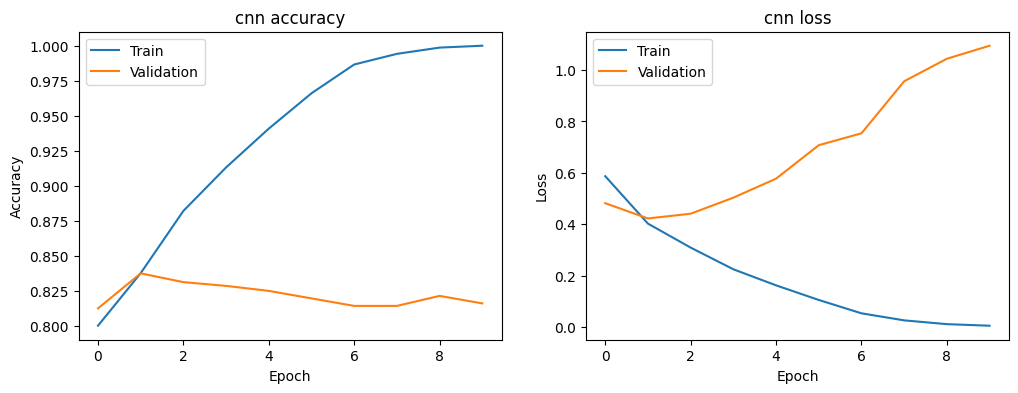

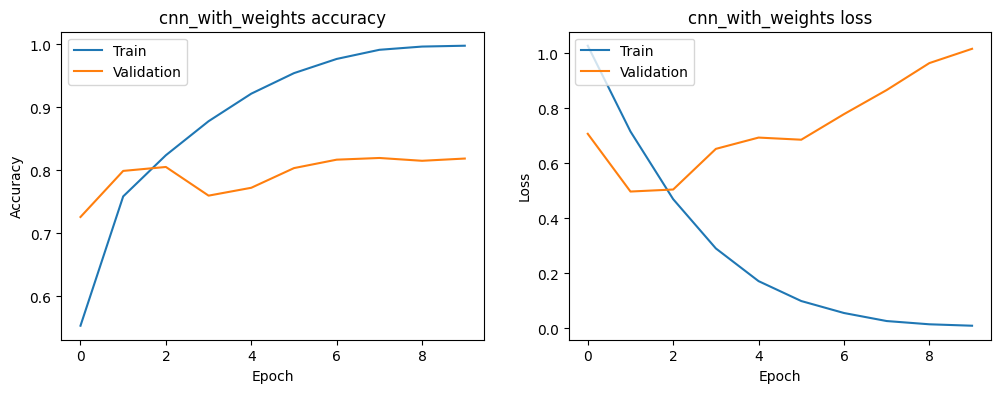

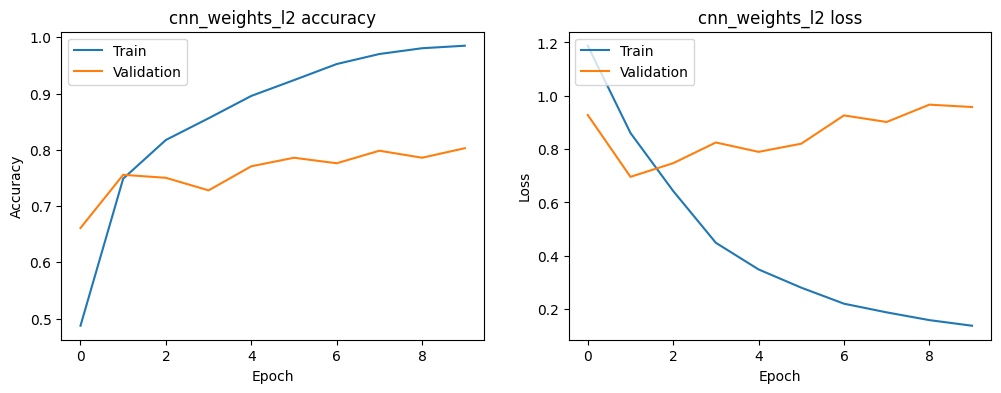

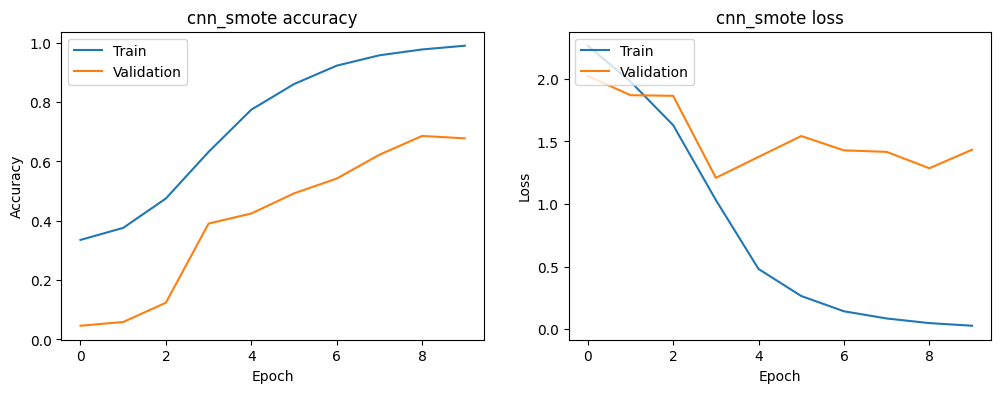

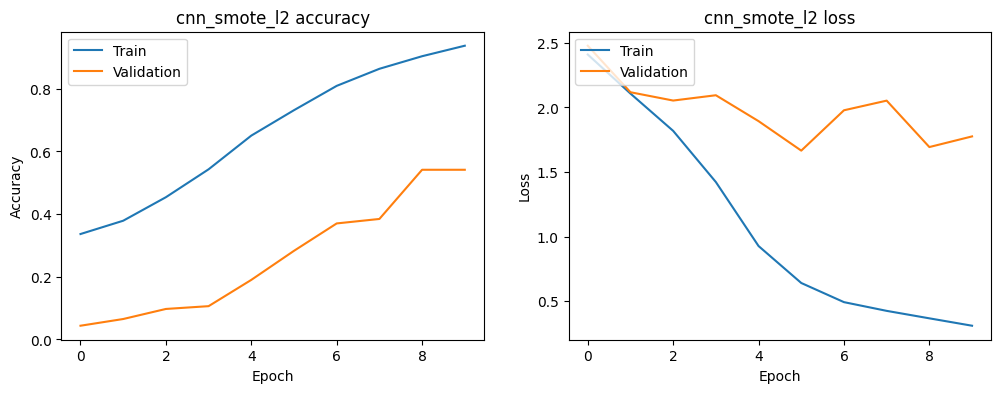

In [19]:
import matplotlib.pyplot as plt

def visualize_history(history, model_name='Model'):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

for model, history in histories.items():
    visualize_history(history, model)


#### Test model

In [20]:
X_test, y_test = test_data
for name, model in models.items():
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    print(f'{name} test accuracy: {test_accuracy:.4f}')
    print(f'{name} test loss: {test_loss:.4f}')

76/76 - 1s - 7ms/step - accuracy: 0.8162 - loss: 1.0452
cnn test accuracy: 0.8162
cnn test loss: 1.0452
76/76 - 1s - 7ms/step - accuracy: 0.8158 - loss: 0.9509
cnn_with_weights test accuracy: 0.8158
cnn_with_weights test loss: 0.9509
76/76 - 1s - 7ms/step - accuracy: 0.7875 - loss: 0.9634
cnn_weights_l2 test accuracy: 0.7875
cnn_weights_l2 test loss: 0.9634
76/76 - 0s - 6ms/step - accuracy: 0.6873 - loss: 1.2764
cnn_smote test accuracy: 0.6873
cnn_smote test loss: 1.2764
76/76 - 1s - 8ms/step - accuracy: 0.5576 - loss: 1.6415
cnn_smote_l2 test accuracy: 0.5576
cnn_smote_l2 test loss: 1.6415


## **Classification Report**

In [21]:
from sklearn.metrics import classification_report

X_test, y_test = test_data

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(f'Classification Report for {name}:')
    print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report for cnn:
              precision    recall  f1-score   support

    Negative       0.33      0.10      0.15       104
     Neutral       0.44      0.45      0.44       363
    Positive       0.89      0.92      0.91      1938

    accuracy                           0.82      2405
   macro avg       0.56      0.49      0.50      2405
weighted avg       0.80      0.82      0.81      2405

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report for cnn_with_weights:
              precision    recall  f1-score   support

    Negative       0.43      0.18      0.26       104
     Neutral       0.45      0.52      0.48       363
    Positive       0.90      0.91      0.90      1938

    accuracy                           0.82      2405
   macro avg       0.59      0.54      0.55      2405
weighted avg       0.81      0.82      0.81      2405

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report for cnn_weights_l2:
    